**Synthesis**

This scrips uses control parameter trajecotries and a pre-trained singer model to first predict syntheis parameters and finally synthesize the sung vowel.

In [1]:
%load_ext autoreload
%autoreload 2

#hsvs includes
from hsvs.model import util
from hsvs.tools import synthesis
import hsvs

# 3rd party dependencies
import numpy as np
import scipy.io as sio  
import soundfile 

import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# singer / sample used for synthesis
model_vowel  = 'o'  # [a,e,i,o,u]
model_singer = 'f5' # [f1 - f9, m1-m11]

# singer / sample used for pitch / Rd trajecotries
control_vowel  = model_vowel  # [a,e,i,o,u]
control_singer = 'f6' # [f1 - f9, m1-m11]

# collecting sorce / output file paths 

control_singer_vowel_dir = control_singer + '_' + control_vowel
model_singer_vowel_dir   = model_singer + '_' + model_vowel
data_path  = os.path.abspath(os.path.join(os.path.dirname(hsvs.__file__), os.pardir, 'data'))
model_path = os.path.join(data_path, 'results', model_singer_vowel_dir, 'predictor' )
control_mat_file = os.path.join(data_path, 'results', control_singer_vowel_dir, 'parameters.mat' )
model_mat_file   = os.path.join(data_path, 'results', model_singer_vowel_dir, 'parameters.mat' )

out_file = os.path.join(data_path, 'results', model_singer_vowel_dir, 'audio', 'synthesized_' + control_singer_vowel_dir + '.wav' )


# load mat file from model for sample rate
model_parameters = sio.loadmat(model_mat_file)
fs = model_parameters['fs'][0,0]

# Load parameter trajectories from .mat file
control_parameters = sio.loadmat(control_mat_file)
control_pitch = control_parameters['f']
control_Rd    = control_parameters['Rd']

In [3]:
# load model, recompile etc.
model = tf.keras.models.load_model(model_path, compile=False)

# to prevent issues with keras.model not storing the custom loss, it's redefined here but left unused
gain_weight = 0.1 # x/dB
Rd_weight   = 1.   # x/Rd
w_weight    = 0.01 * 44100/(2.*np.pi)  # x/Hz
r_weight    = 0.1 # x/dB  

losses = [lambda y_true, y_pred: util.weighted_mse_loss(y_true, y_pred, tf.square(gain_weight)), 
          lambda y_true, y_pred: util.weighted_mse_loss(y_true, y_pred, tf.square(Rd_weight)), 
          lambda y_true, y_pred: util.pole_zero_loss(y_true, y_pred, r_weight, w_weight),
          lambda y_true, y_pred: util.pole_zero_loss(y_true, y_pred, r_weight, w_weight)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=10E-4), loss=losses)

In [4]:
# predict synthesis parameters from control parameters pitch and Rd
gain, Rd, poles, zeros = model.predict([control_pitch, control_Rd], batch_size=1024)

In [5]:
# syntheisze predicted parameter trajectories
x = synthesis.run(control_pitch, Rd, gain, poles, zeros, fs=fs, hop_size=64, verbose=True)

processing source
processing gain
processing filter
100%|██████████| 403584/403584 [00:59<00:00, 6787.31it/s]


In [6]:
# create dirs if they don't exist yet
audio_path = os.path.dirname(out_file)
if not os.path.exists(audio_path):
            os.makedirs(audio_path)
            
# store synthesized audio 
soundfile.write(out_file, x * (0.5/max(abs(x))), int(fs))

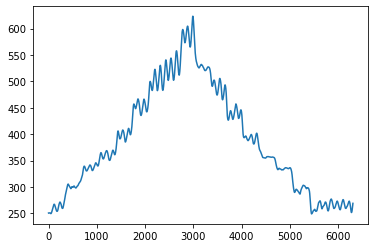

In [11]:
plt.plot(Rd)

In [7]:
# resetting the kernel to flush unused memory
# notification beep.
import numpy as np
import sounddevice
beep = np.sin(np.linspace(0, 1000*np.pi,22050))
sounddevice.play(beep, 44100, blocking=True)

#%reset -f
#exit()